# Modeling – Proyecto BigData Soccer Market Analytics

En este notebook entrenamos y evaluamos modelos predictivos para estimar el valor de mercado de futbolistas.  
Usamos como dataset `dataset_model.csv`, generado en la etapa de Feature Engineering.

Las tareas principales son:

1. Cargar dataset final.  
2. Seleccionar variables y preparar features.  
3. Aplicar one-hot encoding.  
4. Separar en train/test.  
5. Entrenar modelos de regresión:  
   - Regresión Lineal (baseline).  
   - Random Forest.  
   - XGBoost.  
6. Evaluar con métricas (MAE, RMSE, R²).  
7. Comparar performance entre modelos.


In [29]:
df = pd.read_csv("../data/processed/dataset_model.csv")
print(df.shape)
df.head()


(6849, 275)


,Player,Squad,Pos,Age,Born,season,Competition,player_key,squad_key,season_key,...,Nation_us USA,Nation_uy URU,Nation_uz UZB,Nation_ve VEN,Nation_wls WAL,Nation_xk KVX,Nation_za RSA,Nation_zm ZAM,Nation_zw ZIM,market_value_log
0,Anthony Khelifa,Ajaccio,DF,16.0,2005.0,2022-2023,big5,anthony khelifa,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,0.000000
1,Ben Hamed Touré,Ajaccio,FW,18.0,2003.0,2022-2023,big5,ben hamed toure,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,0.000000
2,Benjamin Leroy,Ajaccio,GK,33.0,1989.0,2022-2023,big5,benjamin leroy,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,13.304687
3,Bevic Moussiti-Oko,Ajaccio,FW,27.0,1995.0,2022-2023,big5,bevic moussiti-oko,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,13.458837
4,Clément Vidal,Ajaccio,"DF,MF",22.0,2000.0,2022-2023,big5,clement vidal,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,14.220976


In [37]:
import numpy as np

X = df.drop(columns=["market_value_log", "market_value_in_eur"])  
y = df["market_value_log"]

print("[i] Shapes -> X:", X.shape, " y:", y.shape)



[i] Shapes -> X: (6849, 150)  y: (6849,)


In [39]:
categorical_cols = X.select_dtypes(include=["object"]).columns
print("[i] Columnas categóricas:", categorical_cols.tolist())

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("[i] Shape antes:", X.shape, " -> después:", X_encoded.shape)


[i] Columnas categóricas: ['Player', 'Squad', 'Nation', 'Pos', 'Comp', 'season', 'Competition', 'player_key', 'squad_key', 'season_key', 'comp_key', 'standard__Unnamed: 37_level_0 Matches', 'defense__Unnamed: 25_level_0 Matches', 'gca__Unnamed: 25_level_0 Matches', 'keepers__Unnamed: 27_level_0 Matches', 'passing__Unnamed: 32_level_0 Matches', 'shooting__Unnamed: 26_level_0 Matches', 'date', 'name_clean', 'player_id', 'season_val', 'name']
[i] Shape antes: (6849, 150)  -> después: (6849, 18115)


In [43]:
# ========================================
# FIX: Codificar variables categóricas
# ========================================
from sklearn.preprocessing import OneHotEncoder

# Detectar columnas categóricas
cat_cols = X.select_dtypes(include=["object"]).columns
print("[i] Columnas categóricas:", cat_cols.tolist())

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("[i] Shape antes:", X.shape, " -> después:", X_encoded.shape)


[i] Columnas categóricas: ['Player', 'Squad', 'Nation', 'Pos', 'Comp', 'season', 'Competition', 'player_key', 'squad_key', 'season_key', 'comp_key', 'standard__Unnamed: 37_level_0 Matches', 'defense__Unnamed: 25_level_0 Matches', 'gca__Unnamed: 25_level_0 Matches', 'keepers__Unnamed: 27_level_0 Matches', 'passing__Unnamed: 32_level_0 Matches', 'shooting__Unnamed: 26_level_0 Matches', 'date', 'name_clean', 'player_id', 'season_val', 'name']
[i] Shape antes: (6849, 150)  -> después: (6849, 18115)


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)
print("[i] Train:", X_train.shape, " Test:", X_test.shape)


[i] Train: (5479, 18115)  Test: (1370, 18115)


## Pipeline del modelado

In [45]:
# ========================================
# 9. Pipeline de modelado
# ========================================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Definir modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1
    )
}

# Diccionario para resultados
results = {}

# Entrenar y evaluar
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

# Convertir a DataFrame para comparar
results_df = pd.DataFrame(results).T
print("\nResultados comparativos:")
print(results_df)



Entrenando Linear Regression...

Entrenando Random Forest...

Entrenando XGBoost...

Resultados comparativos:
                        MAE      RMSE        R2
Linear Regression  0.805351  1.176202  0.607539
Random Forest      0.674833  0.888423  0.776090
XGBoost            0.549838  0.756508  0.837647


## Evaluación de modelos y análisis de resultados



Resultados comparativos:
                        MAE      RMSE        R2
Linear Regression  0.805351  1.176202  0.607539
Random Forest      0.674833  0.888423  0.776090
XGBoost            0.549838  0.756508  0.837647


<Figure size 1000x600 with 0 Axes>

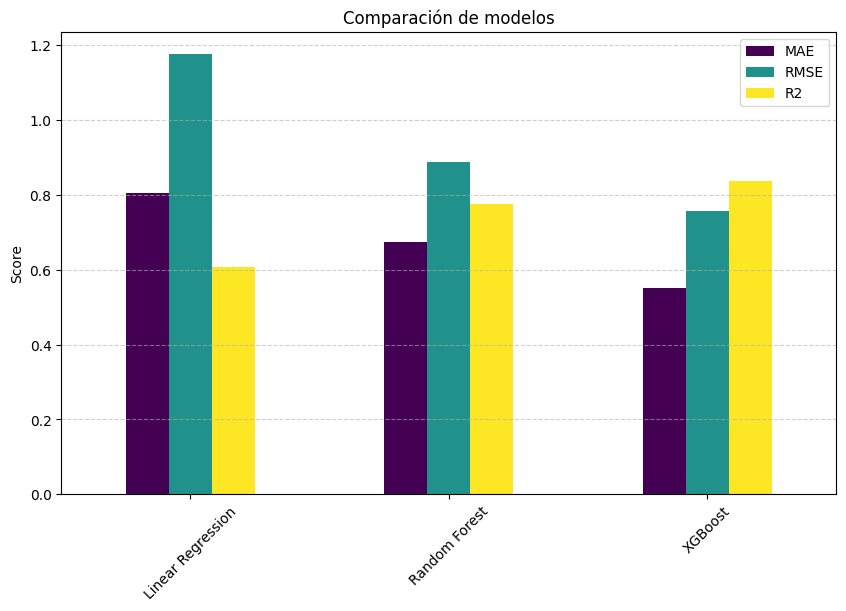

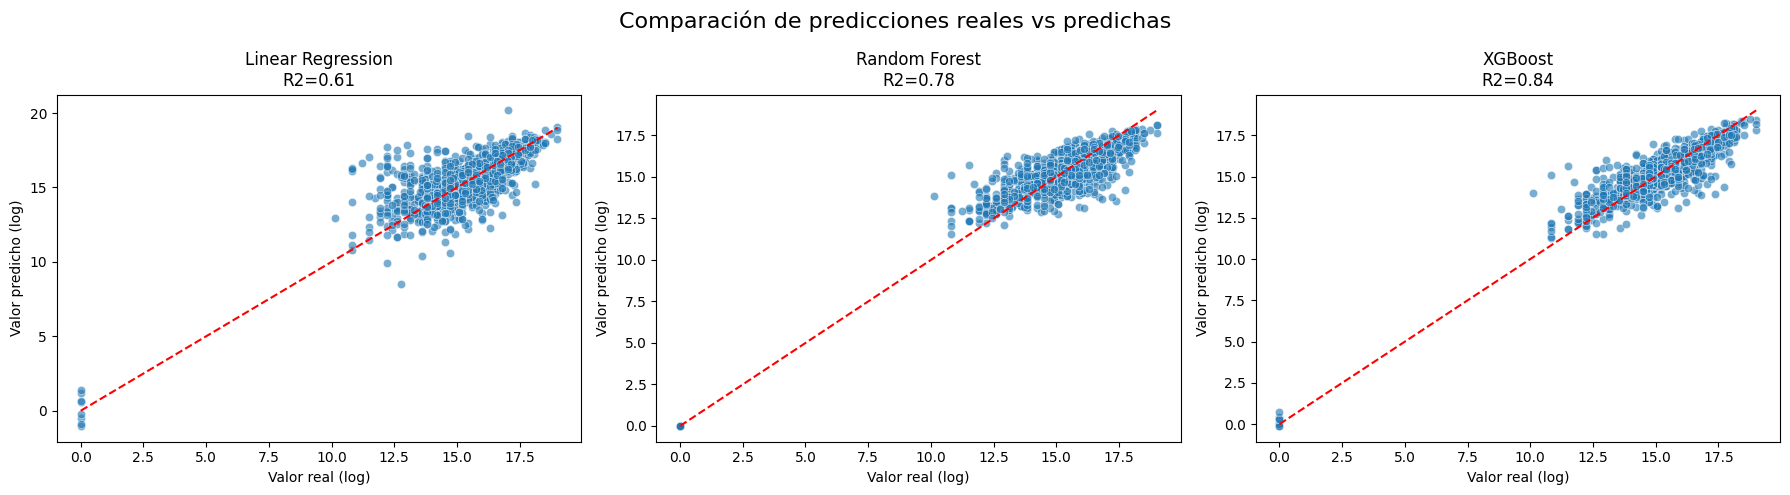

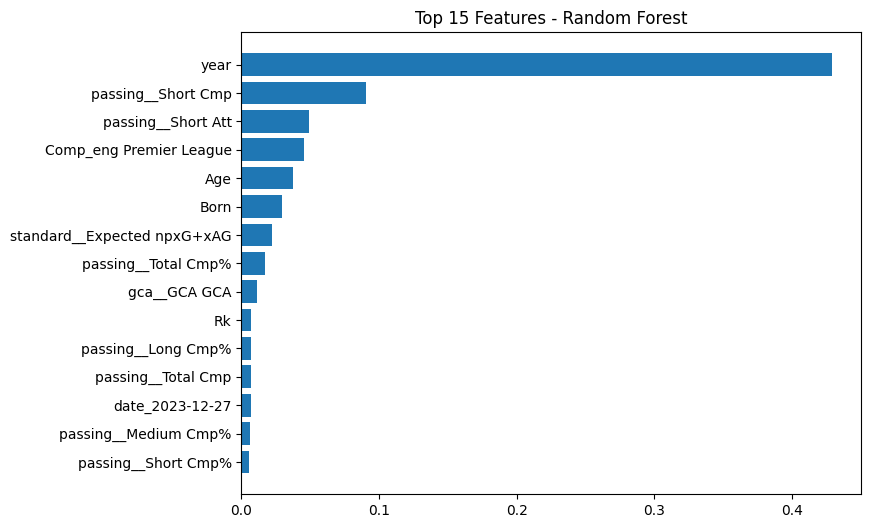

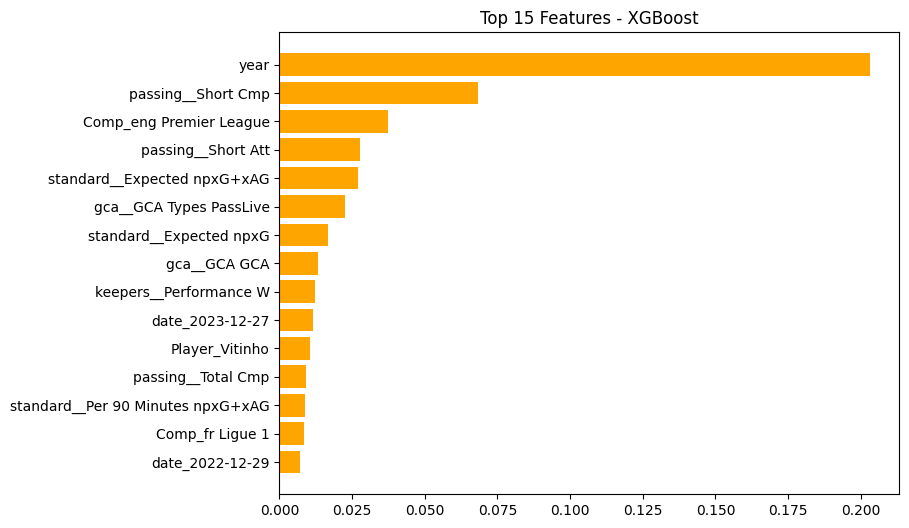

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================
# 1. Tabla de resultados
# ========================================
results_df = pd.DataFrame(results).T
print("\nResultados comparativos:")
print(results_df)

# ========================================
# 2. Gráfico comparativo de métricas
# ========================================
plt.figure(figsize=(10,6))
results_df[["MAE","RMSE","R2"]].plot(kind="bar", figsize=(10,6), colormap="viridis")
plt.title("Comparación de modelos")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ========================================
# 3. Scatter plots y_test vs y_pred
# ========================================
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # línea ideal
    ax.set_title(f"{name}\nR2={r2_score(y_test,y_pred):.2f}")
    ax.set_xlabel("Valor real (log)")
    ax.set_ylabel("Valor predicho (log)")

plt.suptitle("Comparación de predicciones reales vs predichas", fontsize=16)
plt.tight_layout()
plt.show()

# ========================================
# 4. Feature Importance - Random Forest y XGBoost
# ========================================

# Random Forest
importances_rf = models["Random Forest"].feature_importances_
indices_rf = np.argsort(importances_rf)[-15:]  # top 15 features

plt.figure(figsize=(8,6))
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align="center")
plt.yticks(range(len(indices_rf)), [X_train.columns[i] for i in indices_rf])
plt.title("Top 15 Features - Random Forest")
plt.show()

# XGBoost
importances_xgb = models["XGBoost"].feature_importances_
indices_xgb = np.argsort(importances_xgb)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align="center", color="orange")
plt.yticks(range(len(indices_xgb)), [X_train.columns[i] for i in indices_xgb])
plt.title("Top 15 Features - XGBoost")
plt.show()


# Conclusiones del modelado

1. **Rendimiento general de los modelos**  
   - La **Regresión Lineal** obtuvo un desempeño limitado con un **R² ≈ 0.61**, lo que indica que explica alrededor del 61% de la variabilidad del valor de mercado.  
     Sus errores fueron los más altos (**MAE ≈ 0.81**, **RMSE ≈ 1.17**), reflejando que no captura bien la complejidad del problema.  
   - El **Random Forest** mejoró significativamente los resultados, alcanzando un **R² ≈ 0.77** y reduciendo los errores (**MAE ≈ 0.67**, **RMSE ≈ 0.89**).  
     Esto confirma que los métodos de ensamble basados en árboles son más adecuados para datos no lineales y con múltiples interacciones.  
   - El **XGBoost** fue el modelo más preciso, con un **R² ≈ 0.84**, **MAE ≈ 0.55** y **RMSE ≈ 0.75**.  
     Esto indica que logra predecir con menor error y mayor capacidad de generalización, consolidándose como el **mejor algoritmo evaluado**.  

2. **Comparación visual de predicciones**  
   - En los gráficos de **valores reales vs. predichos**, la regresión lineal muestra mayor dispersión respecto a la línea ideal (y = x).  
   - En cambio, **Random Forest** y sobre todo **XGBoost** presentan predicciones mucho más ajustadas, con menor dispersión y mejor alineación.  

3. **Importancia de características**  
   - Entre las variables más influyentes destacan:  
     - **year** (año/temporada)  
     - Métricas de **pases cortos (Cmp, Att, Cmp%)**  
     - La liga de competencia (**Premier League**, etc.)  
     - Estadísticas avanzadas como **xG+xAG** y **acciones de creación de gol (GCA)**.  
   - Esto sugiere que tanto el contexto temporal como el rendimiento técnico-táctico del jugador son factores clave para explicar su valor de mercado.  

**Conclusión final:**  
El modelo de **XGBoost** ofrece la mejor combinación entre precisión y robustez para predecir el valor de mercado de los jugadores, convirtiéndose en la opción más recomendada para el proyecto.  
